# 1 Importamos las bibliotecas que vamos a utilizar

PyTorch Lightning: Para el entrenamiento del modelo. PyTorch Lightning facilita la gestión del ciclo de vida del modelo, como la organización del código, el manejo de los callbacks, y la optimización de los recursos.

Seaborn y Matplotlib: Estas bibliotecas son usadas para la visualización de datos y gráficos. Seaborn facilita gráficos estadísticos con una apariencia más estética, mientras que Matplotlib se utiliza para gráficos más generales y personalizados.

TensorFlow y TensorBoard: Aunque usamos PyTorch para el modelo, TensorFlow y TensorBoard se utilizan para registrar las métricas durante el entrenamiento y la validación. TensorBoard nos permite visualizar estas métricas en tiempo real y hacer un seguimiento del rendimiento del modelo.

PyTorch Forecasting: Esta biblioteca es esencial para trabajar con series temporales. Nos permite crear el objeto TimeSeriesDataSet que es un requisito para utilizar el modelo Temporal Fusion Transformer (TFT), el cual es muy potente para la predicción de series temporales.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorboard as tb 

import logging
import warnings
import pickle

Como es habitual, verificamos si tenemos disponible CUDA en nuestro sistema. En este caso, contamos con una tarjeta gráfica NVIDIA GeForce GTX 1060 de 6GB, por lo que sabemos que CUDA esté habilitado.

## Beneficios de PyTorch Lightning:

PyTorch Lightning simplifica el proceso de entrenamiento de modelos, gestionando automáticamente tareas complejas como la manipulación de CUDA, optimización de parámetros y la gestión de dispositivos. Esto permite centrarse en la lógica del modelo, mientras que Lightning se encarga de la infraestructura subyacente, como la distribución de tareas en múltiples GPUs, ajuste de optimizadores y control de la memoria, facilitando un desarrollo más eficiente y organizado.

In [3]:
import torch
print(torch.cuda.is_available())  # Debería devolver True
print(torch.cuda.get_device_name(0))  # Nombre de tu GPU


True
NVIDIA GeForce GTX 1060 6GB


Para entender cómo funcionan las series temporales en PyTorch Forecasting, creamos un dataset de entrenamiento mínimo. Este dataset nos permitirá construir un TimeSeriesDataSet para entrenar el modelo.

In [4]:
data_ejemplo = pd.DataFrame(
    dict(
        time_idx=np.tile(np.arange(6), 3),
        target=np.array([0,1,2,3,4,5,20,21,22,23,24,25,40,41,42,43,44,45]),
        group=np.repeat(np.arange(3), 6),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
data_ejemplo

,time_idx,target,group,holidays
0,0,0,0,X
1,1,1,0,Black Friday
2,2,2,0,X
3,3,3,0,Christmas
4,4,4,0,X
5,5,5,0,X
6,0,20,1,X
7,1,21,1,Black Friday
8,2,22,1,X
9,3,23,1,Christmas


La columna más importante es time_idx, ya que nos indica la secuencia temporal de nuestros ejemplos.

In [6]:
#creacion de un TimeSeriesDataSet a partir de un DataFrame de pandas
dataset = TimeSeriesDataSet(
    data_ejemplo,
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,
    max_prediction_length=3,
    time_varying_unknown_reals=["target"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

### Explicacion de los argumentos


data_ejemplo: El DataFrame con los datos que usaremos para crear el dataset.

group_ids=["group"]: Define qué columna indica diferentes grupos o series temporales independientes (como diferentes consumidores).

target="target": Es la columna que queremos predecir, en este caso, target.

time_idx="time_idx": Es la columna que marca el tiempo de cada observación, asegurando que los datos estén en el orden correcto.

max_encoder_length=2: El modelo usará los últimos 2 valores anteriores para hacer predicciones.

max_prediction_length=3: El modelo predice los siguientes 3 valores.

time_varying_unknown_reals=["target"]: La columna target cambia con el tiempo y se usa para hacer predicciones.

static_categoricals=["holidays"]: La columna holidays es una variable categórica que no cambia con el tiempo pero puede influir en las predicciones.

target_normalizer=None: No normalizamos los valores de target, se usan tal cual están.

Este dataset es el que usaremos para entrenar el modelo Temporal Fusion Transformer.

In [7]:
# convertimos nuestro dataset a un dataloader
dataloader = dataset.to_dataloader(batch_size=1)

#carga de un batch de datos con next(iter(dataloader)) que devuelve un diccionario con los datos
x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[41., 42.]])
tensor([[2]])


tensor([[43., 44., 45.]])


- Entrada al modelo: Los valores 41 y 42 (pasado).

- Grupo: Pertenecen al tercer grupo (2) de la serie temporal.

- Objetivo a predecir: Los valores futuros 43, 44, y 45.

Así se crea un *TimeSeriesDataSet*. Solo necesitamos asegurarnos de que nuestro dataset esté correctamente ordenado y proporcionar los argumentos adecuados para configurar las series temporales de manera precisa. 

### Consideraciones importantes:
1. **Orden del dataset**:  
   - Es crucial que los datos estén organizados en orden cronológico en función de la columna `time_idx`. Esto garantiza que el modelo procese los datos en la secuencia correcta, simulando cómo se comportaría en un entorno real.

2. **Configuración adecuada de argumentos**:  
   - Al definir las columnas y parámetros como `group_ids`, `target`, y las longitudes de codificador y decodificador, nos aseguramos de que el modelo pueda aprender patrones del pasado y generar predicciones sobre el futuro.

3. **Grupos**:  
   - La creación de grupos (`group_ids`) permite al modelo trabajar con múltiples series temporales dentro del mismo dataset. Esto es útil en casos donde tenemos datos de distintas entidades o categorías (por ejemplo, diferentes tiendas, sensores, o ubicaciones) y queremos modelarlas simultáneamente.

4. **Simplicidad con los datos correctos**:  
   - Siempre que tengamos todos los datos necesarios (secuencias completas, variables relevantes, etc.), configurar y utilizar un *TimeSeriesDataSet* resulta sencillo. Es una herramienta poderosa que agiliza el trabajo con series temporales al proporcionar un formato estándar que modelos avanzados como el Temporal Fusion Transformer pueden entender. 

# Pronóstico de la Demanda de Energía

Este conjunto de datos contiene el consumo de energía eléctrica (en kW) de  clientes con una frecuencia de 15 minutos. Los datos abarcan 4 años.

Realizamos el preprocesamiento de datos siguiendo:

- Agrupación: Agregamos la variable objetivo power_usage por hora.
- Fecha inicial: Identificamos la fecha más temprana en cada serie temporal donde el consumo de energía no es cero.
- Nuevas características: Creamos nuevas variables como mes (month), día (day), hora (hour) y día de la semana (day_of_week).
- Filtrado: Seleccionamos todos los días comprendidos entre el 01-01-2014 y el 07-09-2014.

In [8]:
data = pd.read_csv('data/LD2011_2014.txt', index_col=0, sep=';', decimal=',') # cargamos los datos y usaremos la fecha como índice
data.index = pd.to_datetime(data.index) # convertimos el índice a datetime
data.sort_index(inplace=True) # ordenamos los datos por fecha
data.head(5)    # mostramos los primeros 5 registros

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data = data.resample('1h').mean().replace(0., np.nan)
earliest_time = data.index.min()
df=data[['MT_002', 'MT_004', 'MT_005', 'MT_006', 'MT_008' ]]

1. **Carga y preparación de los datos:**  
   Se cargaron los datos de consumo energético con una frecuencia de 15 minutos, asegurándonos de que las marcas de tiempo sean entendidas como fechas y horas, y se ordenaron cronológicamente.

2. **Reagrupar a intervalos de 1 hora:**  
   Como queremos trabajar con datos por hora, los valores de cada hora se calcularon como el promedio de los 15 minutos correspondientes.

3. **Manejo de valores incorrectos:**  
   Algunos clientes no estaban registrados inicialmente, por lo que su consumo aparece como `0`. Estos valores fueron reemplazados por `NaN` para evitar que afecten el entrenamiento del modelo.

4. **Selección de clientes:**  
   Se eligieron 5 clientes específicos para trabajar con sus series temporales en paralelo. Esto permite aprovechar las capacidades del modelo **Temporal Fusion Transformer**, que maneja múltiples series simultáneamente, capturando patrones y relaciones entre ellas.

---

Para preparar el dataset en el formato esperado por TimeSeriesDataSet, debemos transformar las series temporales, que inicialmente están representadas horizontalmente (cada columna es una serie), a un formato "apilado" verticalmente. Esto permite tratar cada serie como un registro independiente, incluyendo características adicionales que faciliten el análisis temporal.

- Se procesan las series temporales de cada cliente, definiendo un rango activo sin valores faltantes.
- Se agregan características temporales como horas y días desde el inicio, hora del día, día de la semana, mes, etc.
- Todas las series se apilan verticalmente en un único DataFrame.
- Finalmente, se filtran los datos para incluir únicamente un período específico.

In [11]:
# Lista vacía para almacenar cada serie temporal procesada
df_list = []

# Iteramos sobre cada columna del DataFrame original (cada cliente/consumidor)
for label in df:
    # Extraemos la serie temporal correspondiente al cliente actual
    ts = df[label]

    # Identificamos el rango de fechas activo donde la serie no tiene valores faltantes
    # forward fill: llena valores NaN hacia adelante
    # backward fill: llena valores NaN hacia atrás
    start_date = min(ts.fillna(method='ffill').dropna().index)  # Fecha inicial válida
    end_date = max(ts.fillna(method='bfill').dropna().index)    # Fecha final válida

    # Creamos un filtro para limitar los datos al rango activo
    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)  # Llenamos los valores faltantes restantes con 0

    # Creamos un DataFrame temporal con la serie procesada
    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index  # Obtenemos el índice de fechas

    # Agregamos nuevas características temporales:
    # Horas transcurridas desde la fecha más temprana
    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')  # Convertimos a entero
    # Días transcurridos desde la fecha más temprana
    tmp['days_from_start'] = (date - earliest_time).days
    # Fecha original
    tmp['date'] = date
    # Identificación del cliente (columna actual)
    tmp['consumer_id'] = label
    # Hora del día
    tmp['hour'] = date.hour
    # Día del mes
    tmp['day'] = date.day
    # Día de la semana (0 = Lunes, 6 = Domingo)
    tmp['day_of_week'] = date.dayofweek
    # Mes del año
    tmp['month'] = date.month

    # Añadimos el DataFrame temporal a la lista
    df_list.append(tmp)

# Concatenamos todos los DataFrames individuales en uno solo
time_df = pd.concat(df_list).reset_index(drop=True)

# Filtramos los datos para incluir únicamente un rango específico de días desde el inicio
# Esto corresponde al rango de fechas entre 2014-01-01 y 2014-09-07
time_df = time_df[(time_df['days_from_start'] >= 1096)  # Día 1096 = 2014-01-01
                & (time_df['days_from_start'] < 1346)]  # Día 1346 = 2014-09-07


/tmp/ipykernel_173839/1687081920.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  start_date = min(ts.fillna(method='ffill').dropna().index)  # Fecha inicial válida
/tmp/ipykernel_173839/1687081920.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  end_date = max(ts.fillna(method='bfill').dropna().index)    # Fecha final válida
/tmp/ipykernel_173839/1687081920.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  start_date = min(ts.fillna(method='ffill').dropna().index)  # Fecha inicial válida
/tmp/ipykernel_173839/1687081920.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  end_date = max(ts.fillna(method='bfill').dropna().ind

### Nuevas características
Añadimos columnas como hora, día, día de la semana y mes, lo que nos ayuda a capturar patrones temporales importantes para el modelo.

In [12]:
time_df.head(5)

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1


In [15]:
print(time_df.head(5))

       power_usage  hours_from_start  days_from_start                date  \
17544    24.004267             26304             1096 2014-01-01 00:00:00   
17545    23.293030             26305             1096 2014-01-01 01:00:00   
17546    24.537696             26306             1096 2014-01-01 02:00:00   
17547    21.870555             26307             1096 2014-01-01 03:00:00   
17548    22.226174             26308             1096 2014-01-01 04:00:00   

      consumer_id  hour  day  day_of_week  month  
17544      MT_002     0    1            2      1  
17545      MT_002     1    1            2      1  
17546      MT_002     2    1            2      1  
17547      MT_002     3    1            2      1  
17548      MT_002     4    1            2      1  


In [13]:
time_df[['consumer_id','power_usage']].groupby('consumer_id').mean()

,power_usage
consumer_id,
MT_002,27.472588
MT_004,120.573001
MT_005,50.958384
MT_006,183.387773
MT_008,248.884259


Text(0.5, 1.0, 'Power usage of consumers')

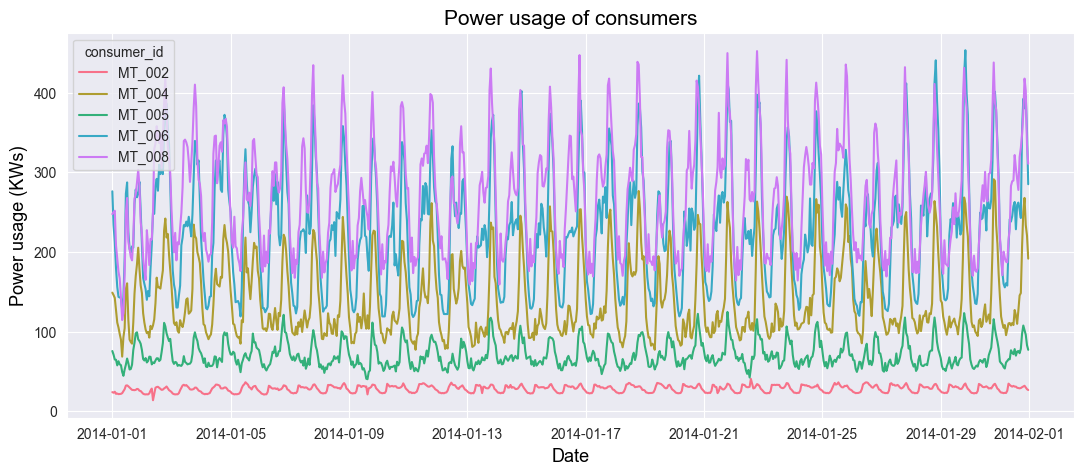

In [ ]:
sns.set_style('darkgrid')
sns.color_palette("tab10")

fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(data=time_df[time_df['month'] == 1], # Filtramos únicamente los datos de enero
             x='date',
             y='power_usage',                       # Consumo de energía
             hue='consumer_id',
             legend='full',
             palette='husl').set_title('Power usage per consumers')

ax.set_xlabel("Date", fontdict={"color":  "black", "size": 13} )
ax.set_ylabel("Power usage (KWs)", fontdict={"color":  "black", "size": 13})
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Power usage of consumers", fontdict={"color":  "black", "size": 15})

### Gráfica que muestra el consumo de los clientes a traves del tiempo (solo enero)

---

Finalmente con los datos ya acomodados procedemos a crear nuestro Dataset de Series de Tiempo

In [ ]:
max_prediction_length = 24 #vamos a predecir 24 horas en el futuro
max_encoder_length = 7*24 #vamos a usar 7 días de datos para predecir
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # normalizamos los datos por grupo con softplus
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# creamos un dataloader para entrenamiento y validación
batch_size = 64 

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [21]:
time_df['consumer_id'].value_counts()

consumer_id
MT_002    6000
MT_004    6000
MT_005    6000
MT_006    6000
MT_008    6000
Name: count, dtype: int64

In [22]:
training.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,26304,32279,1,0,26304,5976,0,191,192
1,26304,32279,1,1,26305,5976,0,192,192
2,26304,32279,1,2,26306,5976,0,193,192
3,26304,32279,1,3,26307,5976,0,194,192
4,26304,32279,1,4,26308,5976,0,195,192
...,...,...,...,...,...,...,...,...,...
30410,26304,32279,1,23904,26304,5976,4,24090,187
30411,26304,32279,1,23904,26304,5976,4,24091,188
30412,26304,32279,1,23904,26304,5976,4,24092,189
30413,26304,32279,1,23904,26304,5976,4,24093,190


In [23]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
5808,26304,32303,1,5808,32112,6000,0,5999,192
11808,26304,32303,1,11808,32112,6000,1,11999,192
17808,26304,32303,1,17808,32112,6000,2,17999,192
23808,26304,32303,1,23808,32112,6000,3,23999,192
29808,26304,32303,1,29808,32112,6000,4,29999,192


In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cuda")
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/tmp/ipykernel_34033/2115510497.py:2: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


25.139617919921875

## Entrenamiento
Iniciamos el entrenamiento de nuestro modelo Temporal Fusion Transformer (TFT) utilizando la interfaz de Trainer de PyTorch Lightning. Durante el proceso, destacamos lo siguiente:

- EarlyStopping: Utilizamos este callback para monitorear la pérdida de validación y detener el entrenamiento si no hay mejoras, evitando el sobreajuste.

- TensorBoard: Registramos las métricas de entrenamiento y validación para poder visualizarlas durante el proceso.
- Quantile Loss: El modelo utiliza una función de pérdida basada en cuantiles, lo que nos permite obtener intervalos de predicción en lugar de un único valor, proporcionando una mejor comprensión de las posibles fluctuaciones en el consumo de energía.
- Atención Multicanal: Usamos 4 cabezas de atención, siguiendo la estructura del artículo original del modelo.

Con estas configuraciones, estamos listos para construir y entrenar nuestro modelo.

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # son 7 quantiles de la distribución
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/mye

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 468/468 [01:08<00:00,  6.86it/s, v_num=0, train_loss_step=4.530, val_loss=3.700, train_loss_epoch=5.950]

Metric val_loss improved. New best score: 3.700


Epoch 5: 100%|██████████| 468/468 [01:08<00:00,  6.86it/s, v_num=0, train_loss_step=2.410, val_loss=4.800, train_loss_epoch=2.510]

Monitored metric val_loss did not improve in the last 5 records. Best score: 3.700. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 468/468 [01:08<00:00,  6.83it/s, v_num=0, train_loss_step=2.410, val_loss=4.800, train_loss_epoch=2.510]


Crearemos un checkpoint con el mejor modelo después de entrenar. Cabe destacar que se activó el early stopping, y ahora también cargaremos el mejor modelo guardado desde ese checkpoint.

In [36]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_0/checkpoints/epoch=5-step=2808.ckpt


/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [34]:
!zip  -r model.zip lightning_logs/lightning_logs/version_0/*

  adding: lightning_logs/lightning_logs/version_0/02808/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/02808/consumer_id/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/02808/consumer_id/tensors.tsv (deflated 47%)
  adding: lightning_logs/lightning_logs/version_0/02808/consumer_id/metadata.tsv (deflated 40%)
  adding: lightning_logs/lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/checkpoints/epoch=5-step=2808.ckpt (deflated 8%)
  adding: lightning_logs/lightning_logs/version_0/events.out.tfevents.1732507328.antonio-desktopPC (deflated 10%)
  adding: lightning_logs/lightning_logs/version_0/hparams.yaml (deflated 90%)
  adding: lightning_logs/lightning_logs/version_0/projector_config.pbtxt (deflated 39%)


In [35]:
#load our saved model again
!unzip model.zip
best_model_path='lightning_logs/lightning_logs/version_1/checkpoints/epoch=8-step=4212.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


Archive:  model.zip
replace lightning_logs/lightning_logs/version_0/02808/consumer_id/tensors.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


FileNotFoundError: [Errno 2] No such file or directory: '/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/lightning_logs/lightning_logs/version_1/checkpoints/epoch=8-step=4212.ckpt'

In [ ]:
# Iniciamos TensorBoard para visualizar las métricas de entrenamiento
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Este código se utiliza para iniciar TensorBoard, una herramienta de visualización de métricas de entrenamiento que se integra con PyTorch Lightning. Aquí te explico cómo funciona cada línea:

- %load_ext tensorboard:
    Esta línea es una magia de IPython que carga la extensión de TensorBoard en el entorno de Jupyter Notebook o IPython. Al cargar esta extensión, puedes usar el comando %tensorboard dentro del cuaderno para interactuar con TensorBoard sin tener que salir del entorno de ejecución.

- %tensorboard --logdir lightning_logs:
    Aquí, se lanza TensorBoard y se le indica a la herramienta que lea los registros (logs) de entrenamiento almacenados en el directorio lightning_logs. Este es el directorio donde PyTorch Lightning guarda los logs de entrenamiento y validación, incluyendo métricas como la pérdida, la precisión, entre otras, que se registran durante el entrenamiento del modelo.
    Al ejecutar este comando, TensorBoard mostrará una interfaz interactiva en el cuaderno, permitiendo visualizar los gráficos de las métricas de entrenamiento y validación, como la evolución de la pérdida y la precisión durante las épocas.

Ahora se empieza a hacer predicciones con el modelo entrenado (best_tft) y evaluar su rendimiento

In [ ]:
train_evaluation_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

actuals = torch.cat([y[0] for x, y in iter(train_evaluation_dataloader)]).to("cuda")
predictions = best_tft.predict(train_evaluation_dataloader)


print((actuals - predictions).abs().nanmean().item())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


3.9748270511627197


1. **`train_evaluation_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=8)`**:
   - Se crea un dataloader para los datos de entrenamiento, pero en este caso se marca como `train=False`, lo que significa que los datos no se usarán para entrenar, sino para hacer evaluaciones o predicciones. Se establece el tamaño del lote (`batch_size`) y el número de trabajadores (`num_workers`).

2. **`actuals = torch.cat([y[0] for x, y in iter(train_evaluation_dataloader)]).to("cuda")`**:
   - Aquí, se recopilan los valores reales de `power_usage` de los datos de entrenamiento. `y[0]` obtiene las etiquetas del dataloader, que son los valores reales (el consumo de energía). Luego se concatenan en un solo tensor y se envían a la GPU (`to("cuda")`) para ser procesados de manera más rápida.

3. **`predictions = best_tft.predict(train_evaluation_dataloader)`**:
   - Usamos el modelo `best_tft` (el mejor modelo guardado) para predecir los valores de consumo de energía para los mismos datos utilizados en `train_evaluation_dataloader`.

4. **`(actuals - predictions).abs().nanmean().item()`**:
   - Aquí se calcula la **pérdida promedio** entre los valores reales y las predicciones utilizando el error absoluto medio (MAE). La operación `(actuals - predictions).abs()` obtiene la diferencia absoluta entre los valores reales y las predicciones, y `nanmean()` calcula el promedio, ignorando cualquier valor `NaN`.

5. **`baseline score on training data is 32.30066680908203`**:
   - Este es el valor de referencia o "puntuación base" en los datos de entrenamiento. Este valor es el resultado esperado si el modelo no hiciera predicciones útiles. Compara el rendimiento real del modelo con esta referencia para evaluar si está mejorando.


In [40]:
training_cutoff

32279

Verificamos el punto de corte entre los datos de entrenamiento, en otras palabras, hasta qué punto se usaran lso datos para entrenar y dese que punto para predicciones.

In [ ]:
#Total datapoints for training
time_df[time_df["hours_from_start"] <= training_cutoff]

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1
...,...,...,...,...,...,...,...,...,...
128735,281.144781,32275,1344,2014-09-06 19:00:00,MT_008,19,6,5,9
128736,318.181818,32276,1344,2014-09-06 20:00:00,MT_008,20,6,5,9
128737,312.289562,32277,1344,2014-09-06 21:00:00,MT_008,21,6,5,9
128738,281.986532,32278,1344,2014-09-06 22:00:00,MT_008,22,6,5,9


In [42]:
#Total datapoints for validation
time_df[time_df["hours_from_start"] > training_cutoff]

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
23520,31.116643,32280,1345,2014-09-07 00:00:00,MT_002,0,7,6,9
23521,25.960171,32281,1345,2014-09-07 01:00:00,MT_002,1,7,6,9
23522,24.715505,32282,1345,2014-09-07 02:00:00,MT_002,2,7,6,9
23523,24.715505,32283,1345,2014-09-07 03:00:00,MT_002,3,7,6,9
23524,24.537696,32284,1345,2014-09-07 04:00:00,MT_002,4,7,6,9
...,...,...,...,...,...,...,...,...,...
128759,249.158249,32299,1345,2014-09-07 19:00:00,MT_008,19,7,6,9
128760,303.030303,32300,1345,2014-09-07 20:00:00,MT_008,20,7,6,9
128761,306.397306,32301,1345,2014-09-07 21:00:00,MT_008,21,7,6,9
128762,279.461279,32302,1345,2014-09-07 22:00:00,MT_008,22,7,6,9


In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


7.308484077453613
tensor([ 1.9333,  7.5378,  3.2137, 10.9527, 12.9050], device='cuda:0')


/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


In [44]:
## using the new pytorch-forecasting method (1.0)
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(7.3085, device='cuda:0')

Ahra se utiliza PyTorch Forecasting para hacer predicciones con el modelo y calcular el **Error Absoluto Medio (MAE)**. 

- **`predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))`**: 
  - Realiza predicciones sobre el conjunto de validación (`val_dataloader`) usando el modelo entrenado (`best_tft`).
  - `return_y=True` hace que también se devuelvan los valores reales (`y`) junto con las predicciones.
  - `trainer_kwargs=dict(accelerator="gpu")` indica que se usará la GPU para acelerar el proceso de predicción.

- **`MAE()(predictions.output, predictions.y)`**:
  - `MAE()` es una función que calcula el **Error Absoluto Medio (MAE)**. El MAE mide la diferencia promedio entre los valores reales y las predicciones, sin tener en cuenta la dirección del error (si es positivo o negativo).
  - `predictions.output` son las predicciones generadas por el modelo.
  - `predictions.y` son los valores reales (etiquetas).

El **MAE** se calcula como el promedio de las diferencias absolutas entre los valores predichos y los valores reales, y es útil para medir qué tan lejos están las predicciones del modelo respecto a los valores reales.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


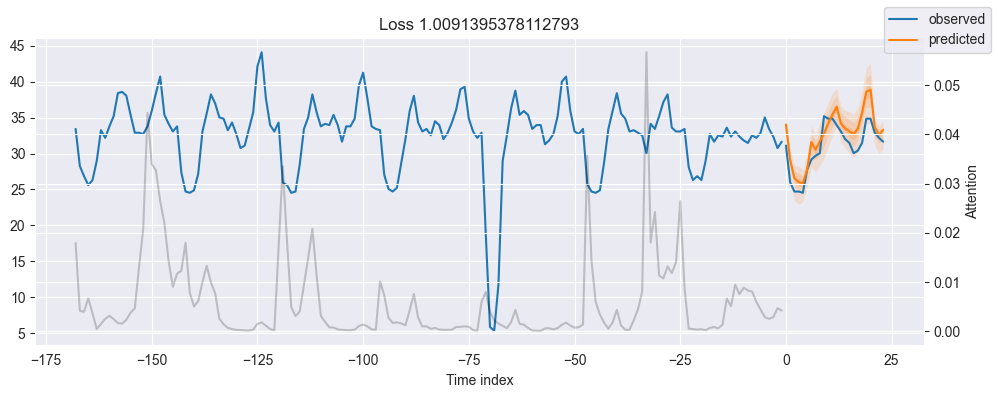

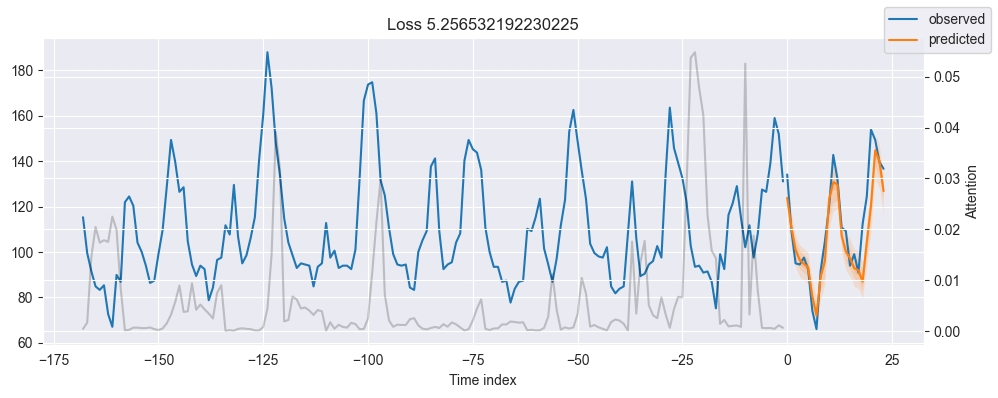

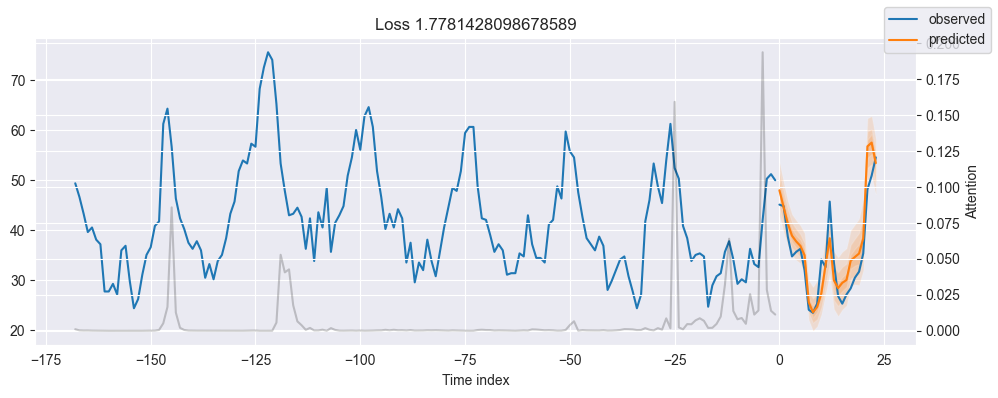

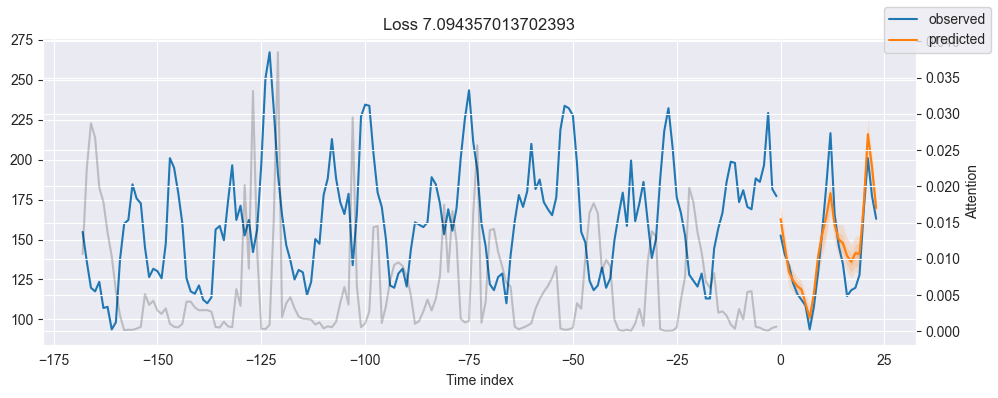

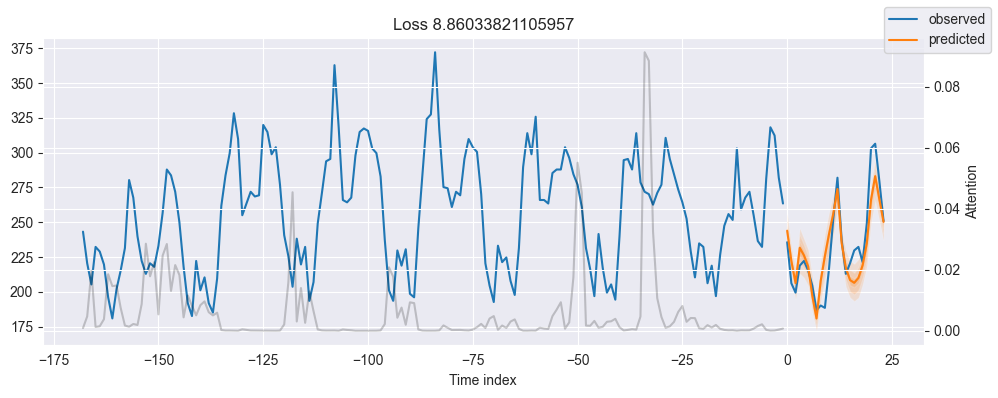

In [45]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
     

En la gráfica:

La línea principal muestra la predicción mediana (quantil 50), es decir, el valor central de las predicciones.
La sombra alrededor de la línea principal representa el rango de predicciones entre otros quantiles, como el 10% y 90%, mostrando la variabilidad en las predicciones.

Esto da una visualización clara del rango de incertidumbre para cada predicción, donde las áreas más anchas indican mayor incertidumbre.

In [ ]:

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)


print('\n')
print(raw_predictions.output._fields)


print('\n')
print(raw_predictions.output.prediction.shape)
#

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([5, 24, 7])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


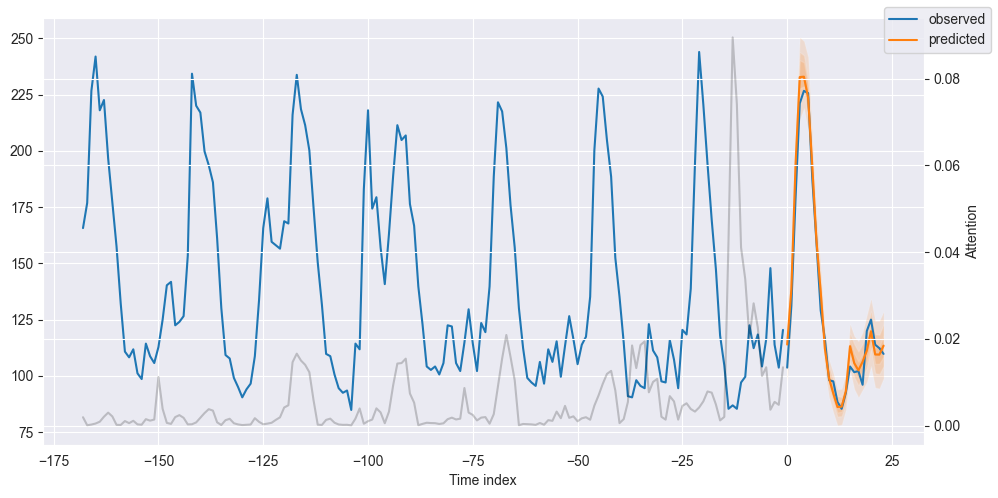

In [47]:


fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction= best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_004") & (x.time_idx_first_prediction == 26512)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, ax=ax);
     


El código genera predicciones "crudas" (sin procesar) a partir del modelo entrenado y las visualiza. Primero, se obtienen tanto las características de entrada como las predicciones en su forma original. Luego, se inspeccionan los campos disponibles en las predicciones, lo que incluye detalles como los valores de salida y los diferentes quantiles generados. Finalmente, se verifica la forma de las predicciones para comprender su estructura y el número de valores generados. Esto es útil para entender cómo se organizan y dimensionan las predicciones del modelo.

In [48]:
26304 + 168//2

26388

En este paso, se generan predicciones para un rango de tiempo futuro, fuera de los datos originales utilizados para entrenar el modelo.

Primero, se selecciona un segmento de datos cercanos al final del conjunto original (lo que se conoce como encoder data), que sirve para dar contexto al modelo sobre los últimos valores observados. A partir de estos datos, se genera un conjunto de datos para el futuro (decoder data), extendiendo la fecha y ajustando las columnas de tiempo, como horas, días, y mes, para alinearlas con el rango de tiempo deseado.

Luego, estos nuevos datos de predicción se concatenan con los datos originales, formando un conjunto completo que abarca tanto el pasado como el futuro. Con estos datos, el modelo hace las predicciones para las horas que aún no se han observado.

Finalmente, las predicciones para el futuro se grafican, mostrando cómo el modelo extrapola más allá de los datos de entrenamiento. En la gráfica, no solo se observan las predicciones, sino que también se puede controlar si mostrar o no los valores observados en el futuro.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/finalDarts/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


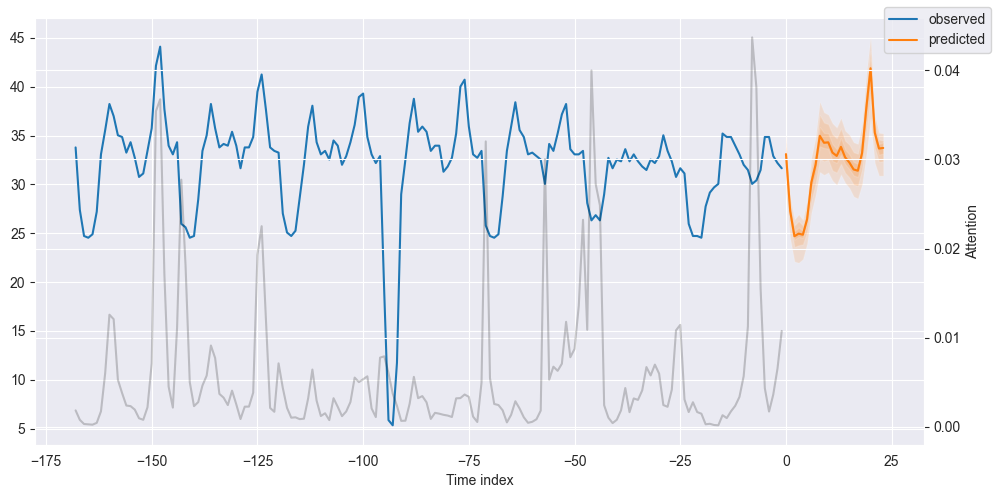

In [ ]:

encoder_data = time_df[lambda x: x.hours_from_start > x.hours_from_start.max() - max_encoder_length]
last_data = time_df[lambda x: x.hours_from_start == x.hours_from_start.max()]



decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.Hour(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)


decoder_data["hours_from_start"] = (decoder_data["date"] - earliest_time).dt.seconds / 60 / 60 + (decoder_data["date"] - earliest_time).dt.days * 24
decoder_data['hours_from_start'] = decoder_data['hours_from_start'].astype('int')
decoder_data["hours_from_start"] += encoder_data["hours_from_start"].max() + 1 - decoder_data["hours_from_start"].min()

decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["hour"] = decoder_data["date"].dt.hour.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))


new_prediction_data=new_prediction_data.query(" consumer_id == 'MT_002'")
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False, ax=ax);

Este paso se refiere a la **interpretación de las predicciones** realizadas por el modelo. Aquí, el proceso se desglosa en dos partes principales:

1. **`interpret_output`**: 
   Esta función se usa para interpretar las predicciones del modelo, es decir, para entender qué características del input (como las variables de entrada) están influyendo más en las predicciones. En este caso, se utiliza el parámetro `reduction="sum"`, lo que significa que se están sumando los efectos de todas las variables para obtener una visión global de la contribución de cada una en la predicción.

2. **`plot_interpretation`**: 
   Luego de calcular la interpretación, esta función genera una visualización que permite observar cómo cada una de las variables del modelo impacta en las predicciones. La gráfica resultante muestra de manera visual la importancia relativa de cada característica o grupo de características, lo que ayuda a entender mejor cómo el modelo toma decisiones.

En resumen, el proceso permite **desglosar las predicciones** y **entender las influencias de las variables**, lo que mejora la transparencia del modelo y puede ser útil para detectar patrones o insights que no son evidentes de inmediato.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

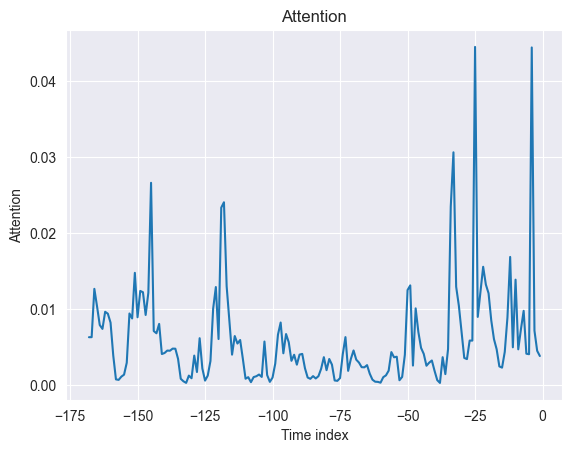

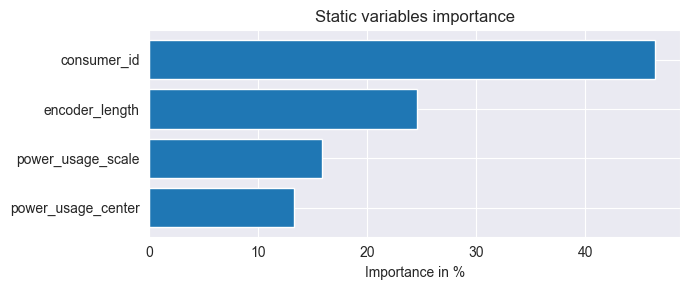

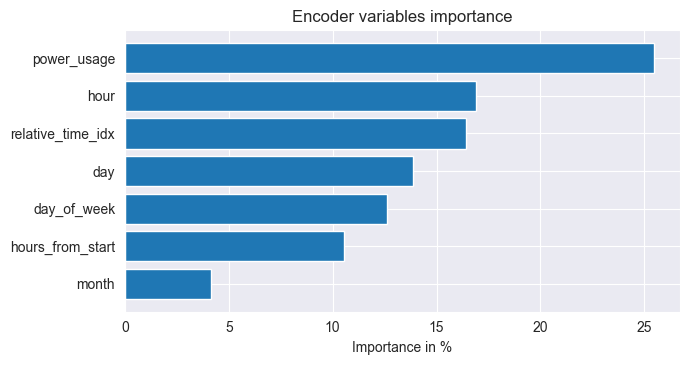

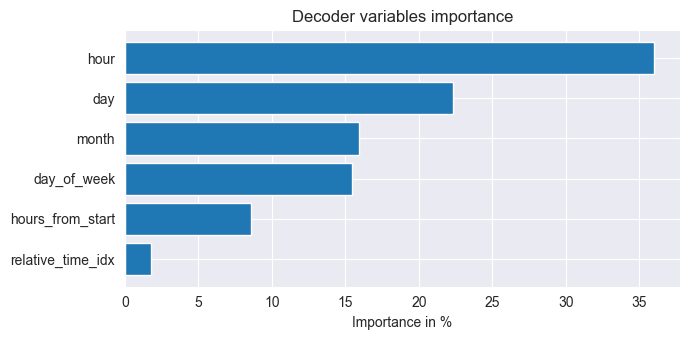

In [57]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

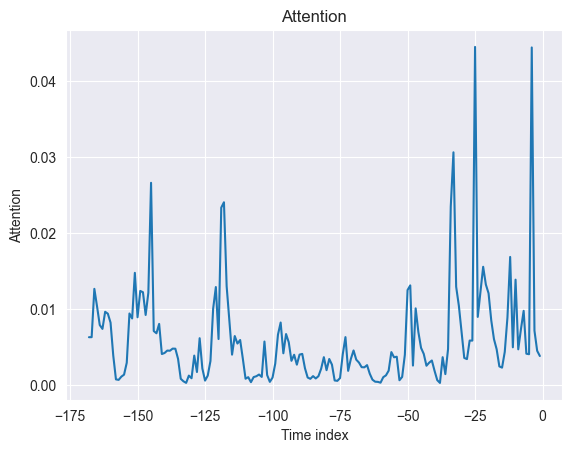

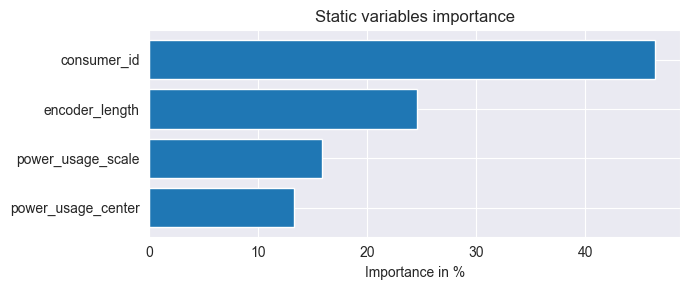

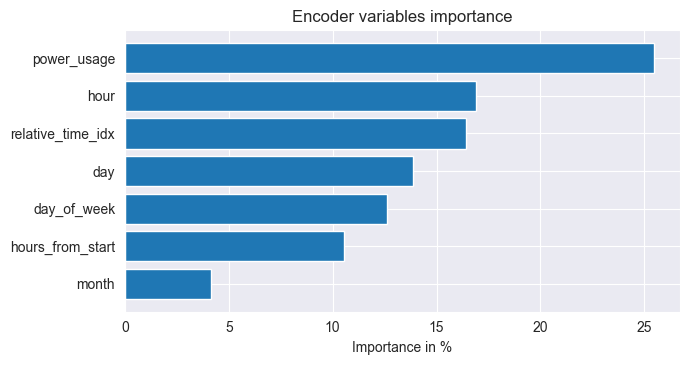

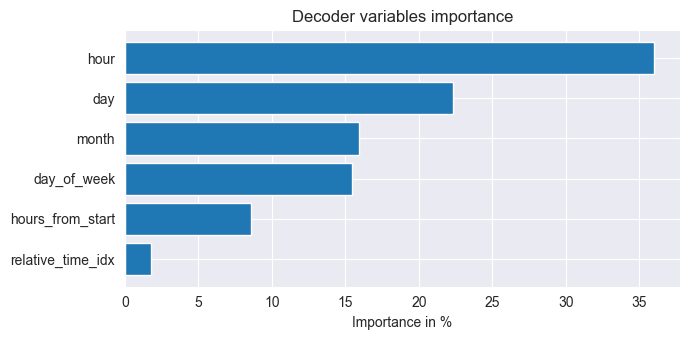

In [ ]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)